# E - When Watts meets Bits

This is an attempt to use Python to solve problem E in IMMC 2024-25. This notebook can be split into the following parts:

1. Set up
   1. Import modules and set up formatting
   2. Set up energy supply data
   3. Define classes
   4. Set up variables
   5. Seeds a random-number generator
2. Try to find an optimal solution
3. Statistics
   1. Sum up all task values
   2. Curve fitting and output

## 1. Set-up

This part sets up everything needed for solving.

### 1.1 Importing modules

This part imports the necessary modules. It also loads fonts to make `matplotlib` graphs look a bit better.

In [1]:
import copy
import enum
import random
from time import time
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from IPython.display import display
from sympy.abc import t
from tqdm.notebook import trange
from matplotlib import font_manager

sp.init_printing()
random.seed(time())

font_path = "TN-Normal.otf"
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = prop.get_name()
plt.rcParams["font.size"] = 12


### 1.2 Set up energy supply data

- `AVAILABLE_ENERGY` defines the available green energy for each hour.
- `RENEWABLE_PRICE` defines the price of renewable energy for each hour.
- `TRAD_PRICE` defines the price for traditional electricity for each hour.

In [2]:
AVAILABLE_ENERGY = [
    0,
    0,
    0,
    0,
    500,
    1400,
    1800,
    2100,
    2400,
    2400,
    2800,
    3200,
    3400,
    3300,
    3100,
    2900,
    2600,
    2500,
    2300,
    1500,
    1000,
    0,
    0,
    0,
]

RENEWABLE_PRICE = [
    0.6,
    0.6,
    0.6,
    0.6,
    0.5,
    0.5,
    0.4,
    0.4,
    0.4,
    0.3,
    0.3,
    0.3,
    0.3,
    0.4,
    0.5,
    0.5,
    0.5,
    0.5,
    0.6,
    0.6,
    0.6,
    0.6,
    0.6,
    0.6,
]
TRAD_PRICE = [
    0.5,
    0.5,
    0.5,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
    1,
    1.2,
    1.3,
    1.3,
    1.2,
    1.1,
    1,
    1,
    1.1,
    1.2,
    1.3,
    1.2,
    1.1,
    1,
    0.8,
    0.6,
]

### 1.3 Define classes

This part defines two classes.

- `Priority` is an `Enum` that stores the priority of the task. The value for each key is the amout of electricity needed (in kWh)
- `Task` is a task. It contains:

  Attributes
  
  - `start_hr` - Start time of the task (hour of the day)
  - `priority` - Priority of the task
  - `equiv` - Equivalent amount of workload, can be a `float`
  - `delay` - Delayed hours of the task
    
  Methods

  - `calc_mark` - Property method that calculates the 'mark' of the task. The algrithm is as follows
 
    $$
        P = 
    \begin{cases}
        100\% \cdot 0.6 \cdot e^{d},& \text{if } u = \text{HIGH}\\
        100\% \cdot 0.7 \cdot e^{d},& \text{if } u = \text{MED}\\
        100\% \cdot 0.8 \cdot e^{d},& \text{if } u = \text{LOW}\\
    \end{cases}
    \text{, where }
    \begin{cases}
    d &= \text{The delay in hours}\\
    u &= \text{The urgency}\\
    \end{cases}
    , M = P \cdot (1 + a)$$

In [3]:
class Priority(enum.Enum):
    HIGH = 80
    MED = 50
    LOW = 30


class Task:
    award: float = 0

    def __init__(self, start_hr: int, priority: Priority, equiv: float, delay: int = 0):
        self.start_hr = start_hr
        self.priority = priority
        self.equiv = equiv
        self.delay = delay

    def delay_task(self):
        self.start_hr += 1
        self.delay += 1

    @property
    def calc_mark(self) -> float:
        marks = 1
        if self.priority == Priority.HIGH:
            marks *= 0.6 * np.exp(self.delay)
        if self.priority == Priority.MED:
            marks *= 0.7 * np.exp(self.delay)
        if self.priority == Priority.LOW:
            marks *= 0.8 * np.exp(self.delay)
        marks *= (1 + self.award)
        return marks

    def __repr__(self) -> str:
        return f"<TASK grade={self.calc_mark:0.2f} at {id(self)}>"

### 1.4 Set up variables

The question defined a series of tasks. We are now going to add them to the list `ORIG_TASKS`.

In [118]:
last_ttl_mark = 0
last_price = None
correct_updated_tasks: List[Dict[int, List[Task]]] = []
energies = {}
green_energies = {}
ORIG_TASKS = []

for i in range(6):
    ORIG_TASKS.append([Task(i, Priority.MED, 6 + 2 / 3), Task(i, Priority.LOW, 10)])

for i in range(6, 8):
    ORIG_TASKS.append([Task(i, Priority.MED, 27.5), Task(i, Priority.LOW, 35)])

for i in range(8, 12):
    ORIG_TASKS.append([Task(i, Priority.HIGH, 28.5), Task(i, Priority.MED, 18)])

for i in range(12, 14):
    ORIG_TASKS.append([Task(i, Priority.HIGH, 27), Task(i, Priority.MED, 47.5)])

for i in range(14, 18):
    ORIG_TASKS.append([Task(i, Priority.HIGH, 38), Task(i, Priority.MED, 20)])

for i in range(18, 22):
    ORIG_TASKS.append(
        [
            Task(i, Priority.HIGH, 12.5),
            Task(i, Priority.MED, 12.5),
            Task(i, Priority.LOW, 10),
        ]
    )

for i in range(22, 24):
    ORIG_TASKS.append(
        [
            Task(i, Priority.MED, 10),
            Task(i, Priority.LOW, 7.5),
        ]
    )

## 2. Try to find a optimal solution

This part is the most time-consuming part. It runs the following over and over again to get a solution.

1. Loop through all the tasks, and randomly deciding whether to delay it.
   - Delaying has the chance of $1/4$
   - Delaying never happens after 23:00, as the question asks for a 24-hour plan.
2. Calculate the energy needed for an entire hour, and, if the renewable energy at that hour is not enough,
   randomly decide whether to delay it.
   - Delaying has the chance of $1/2$
   - Delaying never happens after 23:00, as the question asks for a 24-hour plan.
   - Tasks will be awarded randomly if there is a delay.
3. Calculate the electricity price
4. Calculate the total marks of all tasks
5. If
   $$ \Sigma_{i=1}^n {T_{mark,i}} \gt ( \Sigma{T_{mark}} ) _{max}, \text{where } T_{mark} \text{ is the mark of a task} $$, and
   $$ \Sigma_{i=1}^n {E_i} \lt ( \Sigma{E_i} ) _{min}, \text{where } E \text{ is the price of the energy consumed in an hour}  $$,
   replace $ ( \Sigma{T_{mark}} ) _{max} $ and $ ( \Sigma{E} ) _{max} $ with the $\Sigma_{i=1}^n {T_{mark,i}}$ and $\Sigma_{i=1}^n {E_i}$.

In [119]:
for _ in trange(10_000):
    updated_tasks = {x: [] for x in range(24)}
    energies_current = {x: [] for x in range(24)}
    green_energies_current = {x: [] for x in range(24)}
    orig_tasks = copy.deepcopy(ORIG_TASKS)
    ttl_mark = 0
    energy_used = 0
    price = 0

    for idx, hour in enumerate(orig_tasks):
        for task in reversed(hour):
            updated_tasks[idx].append(task)
            delay_prob = random.random() > 0.75
            if delay_prob and idx < 23:
                task.delay_task()
                updated_tasks[idx].remove(task)
                orig_tasks[idx + 1].append(task)
                continue
            energy_used += task.priority.value * task.equiv
            renewable_part = energy_used - AVAILABLE_ENERGY[idx]
            # If there isn't enough renewable energy, attempt to delay
            delay_prob = random.random() > 0.5
            if delay_prob and idx < 23:
                if task.priority == Priority.LOW:
                    task.delay_task()
                    task.award = random.random()
                    renewable_part += Priority.LOW.value * task.equiv
                    updated_tasks[idx].remove(task)
                    updated_tasks[idx + 1].append(task)

        # Process energy used -> Find electricity price
        renewable_part = energy_used - AVAILABLE_ENERGY[idx]
        if renewable_part < 0:
            # No worries now, get traditional energy supply!
            trad_part = -renewable_part
            price += TRAD_PRICE[idx] * trad_part
        else:
            price += RENEWABLE_PRICE[idx] * renewable_part
        energies_current[idx] = energy_used
        green_energies_current[idx] = renewable_part

    for key, val in updated_tasks.items():
        for i in val:
            ttl_mark += i.calc_mark

    if not last_price:
        last_price = price

    if ttl_mark > last_ttl_mark and price < last_price:
        last_ttl_mark = ttl_mark
        last_price = price
        correct_updated_tasks.append(updated_tasks)
        energies = energies_current
        green_energies = green_energies_current

  0%|          | 0/10000 [00:00<?, ?it/s]

## 3. Statistics

This section does some statistics on the data.

### 3.1 Sum up all task values

As tasks are broken down into smaller, non-integer parts, we need to sum them up for statistics.

In [120]:
data = []
for idx, cut_current in enumerate(correct_updated_tasks):
    data.append([])
    for key, val in cut_current.items():
        high = 0
        med = 0
        low = 0
        for i in val:
            if i.priority == Priority.HIGH:
                high += i.equiv
            elif i.priority == Priority.MED:
                med += i.equiv
            elif i.priority == Priority.LOW:
                low += i.equiv
        data[idx].append([high, med, low])

In [177]:
%%capture
plt.title("Number of tasks for each hour")
plt.rcParams['figure.dpi'] = 100

plt.rcParams['figure.figsize'] = [10, 10]

### 3.2 Curve fitting and output

This part determines the best-fit line in the format

$$ N_{\textbf{TYPE}}(t) = k_9 t^9 + k_8 t^8 + k_7 t^7 + \cdots + k0
\text{ , where } \\
\begin{cases}
N_{\textbf{TYPE}} = \text{The number of tasks} \\
k_0 \cdots k_9 \in \mathbb{R} \\
t = \text{Time (hours)}
\end{cases}
$$

It is a $9^{th}$ power polynomial.

In [168]:
result = np.array(data[-1])
np.insert(result, 0, values=np.arange(24), axis=1)

array([[  0.        ,   0.        ,   0.        ,   0.        ],
       [  1.        ,   0.        ,   6.66666667,  20.        ],
       [  2.        ,   0.        ,  13.33333333,  10.        ],
       [  3.        ,   0.        ,   6.66666667,   0.        ],
       [  4.        ,   0.        ,   6.66666667,  20.        ],
       [  5.        ,   0.        ,   6.66666667,   0.        ],
       [  6.        ,   0.        ,   0.        ,  10.        ],
       [  7.        ,   0.        ,  55.        ,  70.        ],
       [  8.        ,  28.5       ,  18.        ,   0.        ],
       [  9.        ,  28.5       ,  18.        ,   0.        ],
       [ 10.        ,   0.        ,  18.        ,   0.        ],
       [ 11.        ,  28.5       ,   0.        ,   0.        ],
       [ 12.        ,  55.5       ,   0.        ,   0.        ],
       [ 13.        ,   0.        , 113.        ,   0.        ],
       [ 14.        ,   0.        ,   0.        ,   0.        ],
       [ 15.        ,   0

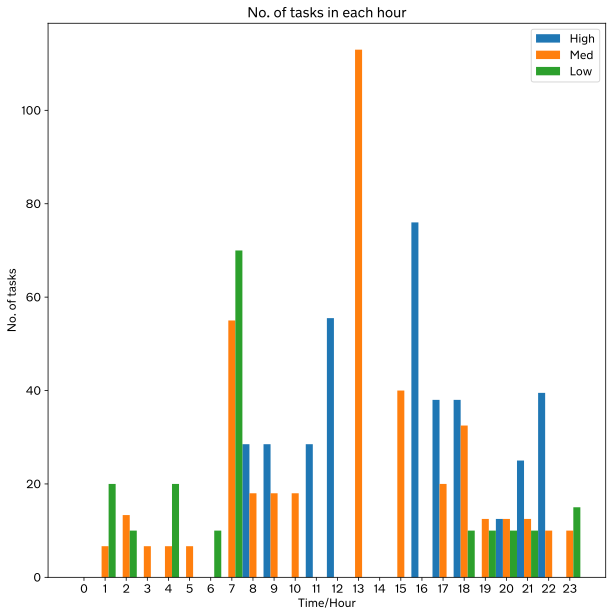

In [178]:
plt.figure()

plt.bar(X - 1/3, result[:, 0], label="High", width=1/3, align="center")
plt.bar(X, result[:, 1], label="Med", width=1/3, align="center")
plt.bar(X + 1/3, result[:, 2], label="Low", width=1/3, align="center")

plt.title("No. of tasks in each hour")
plt.ylabel("No. of tasks")
plt.xlabel("Time/Hour")
plt.legend()
plt.xticks(X)

plt.savefig("A.png")
plt.show()

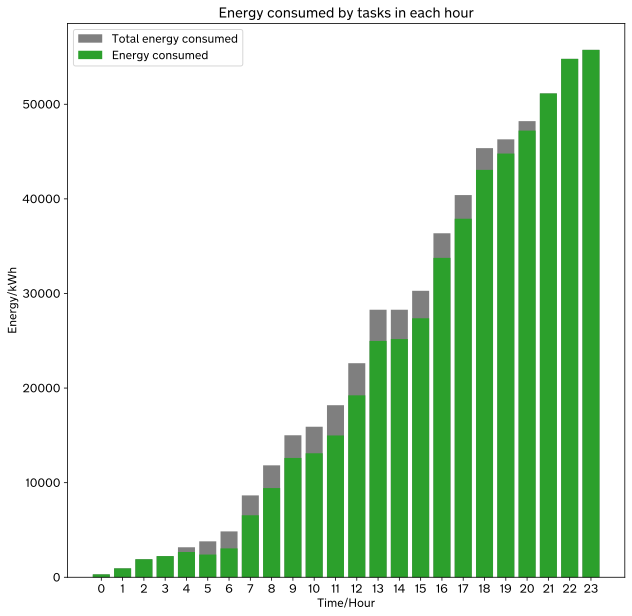

{0: 300,
 1: 933.3333333333334,
 2: 1900.0,
 3: 2233.3333333333335,
 4: 3166.666666666667,
 5: 3800.0000000000005,
 6: 4850.0,
 7: 8650.0,
 8: 11830.0,
 9: 15010.0,
 10: 15910.0,
 11: 18190.0,
 12: 22630.0,
 13: 28280.0,
 14: 28280.0,
 15: 30280.0,
 16: 36360.0,
 17: 40400.0,
 18: 45365.0,
 19: 46290.0,
 20: 48215.0,
 21: 51140.0,
 22: 54800.0,
 23: 55750.0}
{0: 300,
 1: 933.3333333333334,
 2: 1900.0,
 3: 2233.3333333333335,
 4: 2666.666666666667,
 5: 2400.0000000000005,
 6: 3050.0,
 7: 6550.0,
 8: 9430.0,
 9: 12610.0,
 10: 13110.0,
 11: 14990.0,
 12: 19230.0,
 13: 24980.0,
 14: 25180.0,
 15: 27380.0,
 16: 33760.0,
 17: 37900.0,
 18: 43065.0,
 19: 44790.0,
 20: 47215.0,
 21: 51140.0,
 22: 54800.0,
 23: 55750.0}
100.0
100.0
100.0
100.0
84.21052631578948
63.15789473684211
62.88659793814433
75.72254335260115
79.71259509721048
84.01065956029313
82.40100565681962
82.40791643760308
84.97569597878922
88.33097595473834
89.03818953323905
90.42272126816381
92.84928492849285
93.8118811881188
94.9

In [174]:
plt.figure()
plt.bar(X, energies.values(), label="Total energy consumed", align="center", color="tab:grey")
plt.bar(X, green_energies.values(), label="Energy consumed", align="center", color="tab:green")

plt.title("Energy consumed by tasks in each hour")
plt.ylabel("Energy/kWh")
plt.xlabel("Time/Hour")
plt.xticks(X)
plt.legend()

plt.savefig("E.png")
plt.show()

import pprint
pprint.pprint(energies)
pprint.pprint(green_energies)
for key, val in energies.items():
    print(green_energies[key] / val * 100)

[22.83485396 19.61699235 11.81270209]
[24.16982738 16.85339838 10.70233295]
[24.46198865 16.7722351  11.08482133]
[22.14331477 12.54805577 12.98871038]


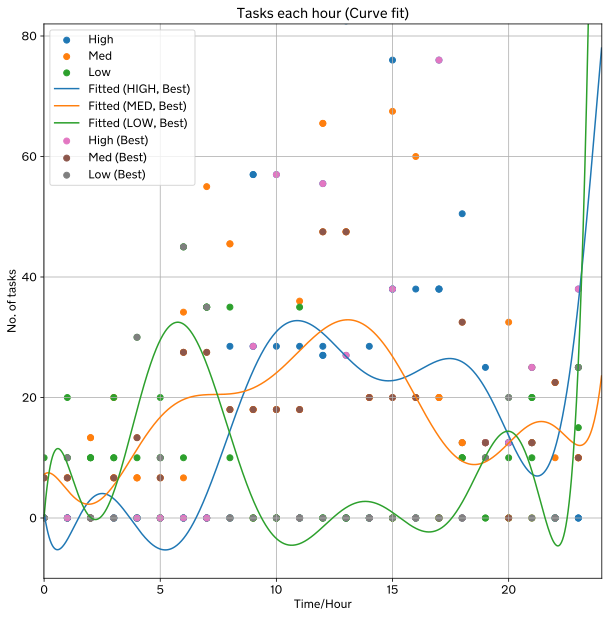

In [175]:
%config InlineBackend.figure_formats = ['svg']
for idx, item in enumerate(data[:-1]):
    item = np.array(item)
    series0 = plt.scatter(np.arange(24), item[:, 0], label="High", color="tab:blue")
    series1 = plt.scatter(np.arange(24), item[:, 1], label="Med", color="tab:orange")
    series2 = plt.scatter(np.arange(24), item[:, 2], label="Low", color="tab:green")
    
    print(np.std(item, axis=0))
    
    X = np.arange(24)
    X_new = np.linspace(0, 24, 1000)
    TIMES = 9

poly1 = np.poly1d(np.polyfit(X, item[:, 0], TIMES))
plt.plot(X_new, poly1(X_new), label="Fitted (HIGH, Best)")

poly2 = np.poly1d(np.polyfit(X, item[:, 1], TIMES))
plt.plot(X_new, poly2(X_new), label="Fitted (MED, Best)")

poly3 = np.poly1d(np.polyfit(X, item[:, 2], TIMES))
plt.plot(X_new, poly3(X_new), label="Fitted (LOW, Best)")


plt.scatter(np.arange(24), item[:, 0], label="High (Best)", color="tab:pink")
plt.scatter(np.arange(24), item[:, 1], label="Med (Best)", color="tab:brown")
plt.scatter(np.arange(24), item[:, 2], label="Low (Best)", color="tab:grey")

# Unify labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="upper left")

plt.xlabel("Time/Hour")
plt.ylabel("No. of tasks")
plt.title("Tasks each hour (Curve fit)")
plt.xlim(-0.01, 24.01)
plt.ylim(-10, 82)
plt.grid()

plt.savefig("B.png")
plt.show()

display(sp.Poly(reversed(poly1.coef), t).as_expr())
display(sp.Poly(reversed(poly2.coef), t).as_expr())
display(sp.Poly(reversed(poly3.coef), t).as_expr())

RSS=[np.float64(9488.170158471446), np.float64(12297.42089022263), np.float64(4053.669801287673)]
STD=[np.float64(395.3404232696436), np.float64(512.3925370926096), np.float64(168.90290838698635)]


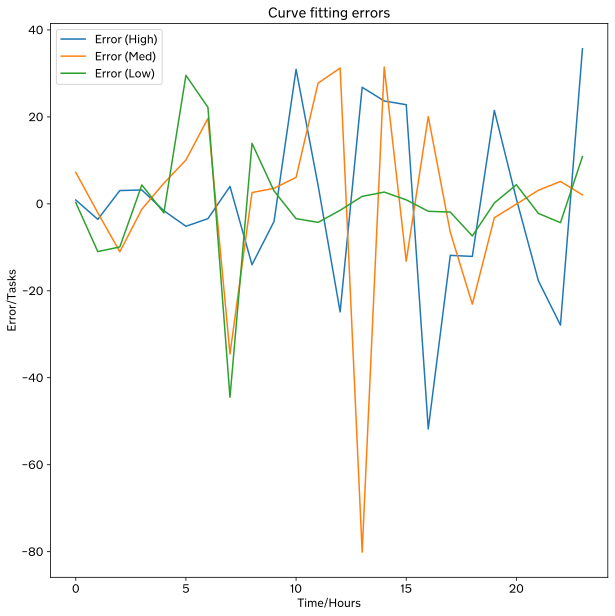

In [176]:
best_fit = np.array(data[-1])
errors = [
    poly1(X) - best_fit[:, 0],
    poly2(X) - best_fit[:, 1],
    poly3(X) - best_fit[:, 2]
]

plt.figure()
plt.plot(X, errors[0], label="Error (High)")
plt.plot(X, errors[1], label="Error (Med)")
plt.plot(X, errors[2], label="Error (Low)")

RSS = [
    np.sum(errors[0]**2),
    np.sum(errors[1]**2),
    np.sum(errors[2]**2)
]
STD = [
    np.var(errors[0]),
    np.var(errors[1]),
    np.var(errors[2]),
]

print(f"{RSS=}")
print(f"{STD=}")

plt.title("Curve fitting errors")
plt.ylabel("Error/Tasks")
plt.xlabel("Time/Hours")
plt.legend()

plt.savefig("C.png")
plt.show()